## Imports

In [203]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

In [2]:
import pyarrow as pa
from datasets import Dataset
from datasets import load_dataset
from datasets import DatasetDict

In [3]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModel

In [5]:
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score,f1_score
from transformers import Trainer
from torch.nn.functional import cross_entropy
from transformers import pipeline

C:\Users\abhij\Desktop\Transformers\transformers\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\abhij\Desktop\Transformers\transformers\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

## Helper Functions

In [308]:
def tokenize(batch):
    '''This function applies tokenizer to a batch of examples; padding=True will pad the examples with
    zeros to the size of the longest one in a batch, and truncation=True will truncate the examples
    to the model's maximum context size.'''
    return tokenizer(batch["Input Text"],padding=True, truncation = True)



def filter_high_frequency_classes(data,col,pct):
    # Get value counts for each category in 'Coverage Code'
    coverage_counts =data[col].value_counts(normalize=True)*100
    
    # Filter to retain only categories with counts greater than 1 pct
    high_frequency_class = coverage_counts[coverage_counts > pct].index
    
    return high_frequency_class


def assign_others(cat,high_frequency_cat):
    if cat in high_frequency_cat:
        return cat
    else:
        return 'other'


def label_int2str(x,label_mapping):
    label_mapping_rev={}
    for k,v in label_mapping.items():
        label_mapping_rev[v]=k
    return label_mapping_rev[x]


def str2int(x,label_mapping):
    return label_mapping[x]



def adjust_input_tokens(classifier_,input_text,idx):
    tokenizer = classifier_.tokenizer
    tokens = tokenizer(input_text)
    token_count = len(tokens["input_ids"])

    if token_count > tokenizer.model_max_length:
        print(f"⚠️ Input at index {idx} has {token_count} tokens and exceeds {tokenizer.model_max_length} tokens! Truncating ...")
        input_text = tokenizer.decode(tokens["input_ids"][:tokenizer.model_max_length-1], skip_special_tokens=True)

    return input_text


def return_predictions(x,label_mapping):
    x = int(x['label'].split('_')[-1])
    return label_int2str(x,label_mapping)


def generate_prediction(model_,input_,idx=None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    classifier_ = pipeline("text-classification",model= model_["model_id"],device=device)
    idx = 0 if None else idx
    custom_input = adjust_input_tokens(classifier_,input_,idx)
    preds = classifier_(custom_input, return_all_scores=True)
    
    return give_score_map(preds[0],model_["labels"])



def give_score_map(prediction,labels):
    score_map = {}
    for score_i in prediction:
        score_map[label_int2str(int(score_i['label'].split('_')[1]),labels)]=score_i["score"]
    return score_map


def plot_confusion_matrix(y_preds, y_true, labels, xtick_rotation=45):
    """
    Plots a normalized confusion matrix with customizable x-tick rotation.

    Parameters:
    - y_preds: Predicted labels
    - y_true: True labels
    - labels: List of class labels
    - xtick_rotation: Rotation angle for x-axis tick labels (default: 45 degrees)
    """
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    
    fig, ax = plt.subplots(figsize=(20, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    
    plt.xticks(rotation=xtick_rotation)  # Rotate x-tick labels
    plt.title("Normalized Confusion Matrix")
    plt.show()



def show_score_bar_single(input_text,score_map):
    if len(score_map)>40:
        sample = pd.DataFrame({"Scores":score_map.values(),
             "Labels":score_map.keys()}).sort_values(by='Scores',ascending=False).head(40)
        sample = sample.sort_values(by="Labels",ascending=True)
        score_map = {}
        for idx in sample.index:
            score_map[sample.loc[idx,'Labels']] = sample.loc[idx,'Scores']

    plt.bar(score_map.keys(),[100*x for x in score_map.values()],color='C0')
    plt.title(f"{input_text[:80]}")
    plt.ylabel("Class probability (%)")
    plt.grid(True,linewidth=0.1)
    plt.xticks(rotation=90)
    plt.show()


def show_score_bar_multiple(input_text, score_dict):
    """
    Plots bar charts for three categories: Cat1, Cat2, and Cat3.

    Parameters:
    - input_text (str): The input text for which scores are displayed.
    - score_dict (dict): A dictionary containing scores for 'Cat1', 'Cat2', and 'Cat3'.
    """

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 1, 1]})
    
    categories = ["Cat1", "Cat2", "Cat3"]
    
    for i, cat in enumerate(categories):
        if cat not in score_dict:
            continue  # Skip if category is missing
        
        score_map = score_dict[cat]
        
        # Limit to top 40 categories for Cat3
        if cat == "Cat3" and len(score_map) > 40:
            sample = pd.DataFrame({
                "Scores": score_map.values(),
                "Labels": score_map.keys()
            }).sort_values(by='Scores', ascending=False).head(40)

            sample = sample.sort_values(by="Labels",ascending=True)

            score_map = {row['Labels']: row['Scores'] for _, row in sample.iterrows()}

        ax = axes[i]
        ax.bar(score_map.keys(), [100 * x for x in score_map.values()], color=f"C{i}")
        ax.set_title(f"{cat} Predictions", fontsize=14)
        ax.set_ylabel("Class Probability (%)")
        ax.grid(True, linewidth=0.1)
        ax.set_xticklabels(score_map.keys(), rotation=90, fontsize=10)

    plt.suptitle(f"Text: {input_text[:80]}", fontsize=16)
    plt.tight_layout()
    plt.show()


In [309]:
def generate_prediction_dataset(df,model):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:",device)
    classifier_ = pipeline("text-classification",model= model["model_id"],device=device)
    input_col = 'Input Text'
    
    if model['target_col']=='Cat1 Merged':
        df['Input Text'] = df['Title']+", "+df['Text']
    elif model['target_col']=='Cat2 Merged':
        df['Input Text'] = df['Input Text']+", "+df['Cat1 Predictions']
    elif model['target_col']=='Cat3 Merged':
        df['Input Text'] = df['Title']+" | "+df['Cat1 Predictions']+" | "+df["Cat2 Predictions"]+", "+df['Text']
    else:
        print("Input data not correct...!")
        return
        

    custom_input = [adjust_input_tokens(classifier_,df.loc[idx,model['input_col']],idx) for idx in df.index]
    correct = [df.loc[idx,model['target_col']] for idx in df.index]
    preds = classifier_(custom_input, top_k=1)
    pred_df = pd.DataFrame(preds,index= df.index)
    pred_df['Input Text'] = custom_input
    pred_df['Predictions'] = pred_df[0].apply(lambda x:return_predictions(x,label_mapping=model["labels"]))
    pred_df['Confidence'] = pred_df[0].apply(lambda x:x['score'])
    pred_df['Actual'] = correct
    pred_df.drop(0,axis=1,inplace=True)
    
    return pred_df

In [310]:
def hierarchical_evaluation(df):
    """Evaluates hierarchical classification performance"""
    
    # Accuracy at each level
    cat1_acc = accuracy_score(df["Cat1 Merged"], df["Cat1 Predictions"])
    
    # Filter samples where Cat1 is correct
    valid_cat2 = df[df["Cat1 Merged"] == df["Cat1 Predictions"]]
    cat2_acc = accuracy_score(valid_cat2["Cat2 Merged"], valid_cat2["Cat2 Predictions"])
    
    # Filter samples where Cat1 & Cat2 are correct
    valid_cat3 = valid_cat2[valid_cat2["Cat2 Merged"] == valid_cat2["Cat2 Predictions"]]
    cat3_acc = accuracy_score(valid_cat3["Cat3 Merged"], valid_cat3["Cat3 Predictions"])
    
    # Hierarchical Exact Match Ratio (HEMR)
    exact_match = (df["Cat1 Merged"] == df["Cat1 Predictions"]) & \
                  (df["Cat2 Merged"] == df["Cat2 Predictions"]) & \
                  (df["Cat3 Merged"] == df["Cat3 Predictions"])
    
    hemr = exact_match.mean()  # Fraction of exact matches

    # Precision, Recall, F1 at each level
    precision_cat1, recall_cat1, f1_cat1, _ = precision_recall_fscore_support(
        df["Cat1 Merged"], df["Cat1 Predictions"], average="weighted"
    )
    
    precision_cat2, recall_cat2, f1_cat2, _ = precision_recall_fscore_support(
        df["Cat2 Merged"], df["Cat2 Predictions"], average="weighted"
    )

    precision_cat3, recall_cat3, f1_cat3, _ = precision_recall_fscore_support(
        df["Cat3 Merged"], df["Cat3 Predictions"], average="weighted"
    )

    # Print results
    print(f">>Accuracy :- \nCat1: {cat1_acc:.4f}, \nCat2: {cat2_acc:.4f}, \nCat3: {cat3_acc:.4f}")
    
    print(f">>F1 Score :- \nCat1: {f1_cat1:.4f}, \nCat2: {f1_cat2:.4f}, \nCat3: {f1_cat3:.4f}")

    print(f">>HEMR (Hierarchical Exact Match Ratio):- {hemr:.4f}")



In [311]:
def plot_hierarchical_results(df):
    """Visualizes the hierarchical classification results"""

    # ---- 1. Accuracy Bar Plot ----
    accuracies = {
        "Cat1 Accuracy": (df["Cat1 Merged"] == df["Cat1 Predictions"]).mean(),
        "Cat2 Accuracy": (df["Cat2 Merged"] == df["Cat2 Predictions"]).mean(),
        "Cat3 Accuracy": (df["Cat3 Merged"] == df["Cat3 Predictions"]).mean(),
        "Hierarchical Exact Match": ((df["Cat1 Merged"] == df["Cat1 Predictions"]) & 
                                     (df["Cat2 Merged"] == df["Cat2 Predictions"]) & 
                                     (df["Cat3 Merged"] == df["Cat3 Predictions"])).mean()
    }

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Hierarchical Classification Accuracy")
    plt.xticks(rotation=30)
    plt.show()

    # ---- 2. Hierarchical Consistency Heatmap ----
    consistency_matrix = np.zeros((3, 3))  # 3 levels: Cat1, Cat2, Cat3

    consistency_matrix[0, 0] = accuracies["Cat1 Accuracy"]
    consistency_matrix[1, 1] = accuracies["Cat2 Accuracy"]
    consistency_matrix[2, 2] = accuracies["Cat3 Accuracy"]

    consistency_matrix[1, 0] = ((df["Cat1 Merged"] == df["Cat1 Predictions"]) & 
                                (df["Cat2 Merged"] == df["Cat2 Predictions"])).mean()
    
    consistency_matrix[2, 1] = ((df["Cat2 Merged"] == df["Cat2 Predictions"]) & 
                                (df["Cat3 Merged"] == df["Cat3 Predictions"])).mean()

    plt.figure(figsize=(6, 5))
    sns.heatmap(consistency_matrix, annot=True, cmap="coolwarm", fmt=".2f",
                xticklabels=["Cat1", "Cat2", "Cat3"],
                yticklabels=["Cat1", "Cat2", "Cat3"])
    plt.title("Hierarchical Consistency Heatmap")
    plt.show()

    # ---- 3. Hierarchical Exact Match Distribution ----
    df["Exact Match"] = ((df["Cat1 Merged"] == df["Cat1 Predictions"]) & 
                         (df["Cat2 Merged"] == df["Cat2 Predictions"]) & 
                         (df["Cat3 Merged"] == df["Cat3 Predictions"])).astype(int)

    plt.figure(figsize=(5, 4))
    sns.histplot(df["Exact Match"], bins=2, discrete=True, kde=False)
    plt.xticks([0, 1], ["Incorrect", "Exact Match"])
    plt.ylabel("Count")
    plt.title("Distribution of Hierarchical Exact Matches")
    plt.show()

-----------
## Loading Data and Setting Model Config

In [9]:
df = pd.read_csv(r'C:\Users\abhij\Desktop\Transformers\Notebooks\Talentica\data_.csv')

In [11]:
cat1_label_mapping = {'baby products': 0, 'beauty': 1, 'grocery gourmet food': 2, 
                      'health personal care': 3, 'pet supplies': 4, 'toys games': 5}

cat2_label_mapping = {'action toy figures': 0, 'baby toddler toys': 1, 'bath body': 2, 
                      'beverages': 3, 'candy chocolate': 4, 'cats': 5, 'diapering': 6, 
                      'dogs': 7, 'dress up pretend play': 8, 'feeding': 9, 'fish aquatic pets': 10,
                      'fragrance': 11, 'games': 12, 'hair care': 13, 'health care': 14, 
                      'household supplies': 15, 'learning education': 16, 'makeup': 17, 
                      'medical supplies equipment': 18, 'nursery': 19, 'nutrition wellness': 20, 
                      'other': 21, 'pantry staples': 22, 'personal care': 23, 'skin care': 24, 
                      'stuffed animals plush': 25}

cat3_label_mapping = {'accessories': 0, 'adult toys games': 1, 'allergy': 2, 
                      'alternative medicine': 3, 'animals figures': 4, 'apparel accessories': 5, 
                      'bathroom aids safety': 6, 'bedding': 7, 'beds furniture': 8, 'board games': 9, 
                      'body': 10, 'braces': 11, 'breastfeeding': 12, 'building sets': 13, 'card games': 14, 
                      'carriers travel products': 15, 'cleaning tools': 16, 'cleansers': 17, 'coffee': 18, 'collars': 19, 
                      'conditioners': 20, 'cooking baking supplies': 21, 'craft kits': 22, 'daily living aids': 23, 
                      'deodorants antiperspirants': 24, 'disposable diapers': 25, 'doll accessories': 26, 'dolls': 27, 
                      'electronic toys': 28, 'eyes': 29, 'face': 30, 'feeding watering supplies': 31, 'figures': 32, 
                      'first aid': 33, 'food': 34, 'foot care': 35, 'furniture': 36, 'gates doorways': 37, 'grooming': 38, 
                      'hair color': 39, 'hair loss products': 40, 'hands nails': 41, 'health care': 42, 'health monitors': 43, 
                      'health supplies': 44, 'herbs': 45, 'household batteries': 46, 'household cleaning': 47, 'houses': 48, 
                      'incontinence': 49, 'jigsaw puzzles': 50, 'lip care products': 51, 'lips': 52, 'litter housebreaking': 53, 
                      'massage relaxation': 54, 'men s': 55, 'mobility aids equipment': 56, 'model building kits tools': 57, 
                      'nails': 58, 'nutrition bars drinks': 59, 'oral hygiene': 60, 'pain relievers': 61, 
                      'paper plastic': 62, 'play trains railway sets': 63, 'playsets': 64, 'pretend play': 65, 'pumps filters': 66, 
                      'safer sex': 67, 'sauces': 68, 'science': 69, 'scooters wagons': 70, 'shampoos': 71, 'shaving hair removal': 72, 
                      'solid feeding': 73, 'sports supplements': 74, 'styling products': 75, 'styling tools': 76, 'tea': 77, 'toys': 78, 
                      'training behavior aids': 79, 'treats': 80, 'unknown': 81, 'vitamins supplements': 82, 'women s': 83}


In [266]:
model_cat1 = {"target_col":"Cat1 Merged",
             "input_col":"Input Text",
             "labels":cat1_label_mapping,
             "model_id": "abhxaxhbshxahxn/talentica_cat1"}

model_cat2 = {"target_col":"Cat2 Merged",
             "input_col":"Input Text",
             "labels":cat2_label_mapping,
             "model_id": "abhxaxhbshxahxn/talentica_cat2"}

model_cat3 = {"target_col":"Cat3 Merged",
             "input_col":"Input Text",
             "labels":cat3_label_mapping,
             "model_id": "abhxaxhbshxahxn/talentica_cat3"}

In [267]:
model = {"model_cat1":model_cat1,
        "model_cat2":model_cat2,
        "model_cat3":model_cat3,}

-----
## Generating prediction on single input..


In [312]:
input_s = df.loc[6818].to_dict()

In [313]:
input_s

{'productId': 'B000L3XYZ4',
 'Title': 'Drinkwell Platinum Pet Fountain 168oz',
 'userId': 'A2NZVTTHAR94IK',
 'Time': 1357948800,
 'Text': 'I originally purchased this in September of 2012. I was extremely excited to get the unit as I had read all the reviews and I wanted to see how my 3 amigos would react. The unit was simple to set up and I had the unit running in no time. Oh, I highly recommend the Drinkwell Platinum fountain matDrinkwell Platinum Fountain Mat, MAT-D2for this unit. I did purchase the mat the day I purchased the unit and I can tell you it is a lifesaver. My kittehs took to playing in the water and some did spill out. The mat caught all the water and kept my laminate flooring from being damaged in any way at all. The mat also fits the unit perfectly and looks like it belongs with the unit. Ok, back to the 3 amigos. They simply love this fountain. At first they were typical kittehs. They walked around for a bit and would stare, and then act as if it were not there. Fina

In [314]:
model_ = model["model_cat1"]
input_ = input_s['Title']+", "+input_s['Text']
prediction_cat1 = generate_prediction(model_,input_,idx=None)
final_ans_cat1 = max(prediction_cat1,key=prediction_cat1.get)

Token indices sequence length is longer than the specified maximum sequence length for this model (1831 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index None has 1831 tokens and exceeds 512 tokens! Truncating ...


In [315]:
model_ = model["model_cat2"]
input_ = input_s['Title']+", "+input_s['Text']+", " + final_ans_cat1
prediction_cat2 = generate_prediction(model_,input_,idx=None)
final_ans_cat2 = max(prediction_cat2,key=prediction_cat2.get)

Token indices sequence length is longer than the specified maximum sequence length for this model (1834 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index None has 1834 tokens and exceeds 512 tokens! Truncating ...


In [316]:
model_ = model["model_cat3"]
input_ = input_s['Title']+" | "+final_ans_cat1+" | "+final_ans_cat2+", "+input_s['Text']
prediction_cat3 = generate_prediction(model_,input_,idx=None)
final_ans_cat3 = max(prediction_cat3,key=prediction_cat3.get)

Token indices sequence length is longer than the specified maximum sequence length for this model (1836 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index None has 1836 tokens and exceeds 512 tokens! Truncating ...


In [317]:
score_dict = {"Cat1":prediction_cat1,
             "Cat2":prediction_cat2,
             "Cat3":prediction_cat3}

-------------

In [318]:
# show_score_bar_single(input_s['Text'],prediction_cat3)

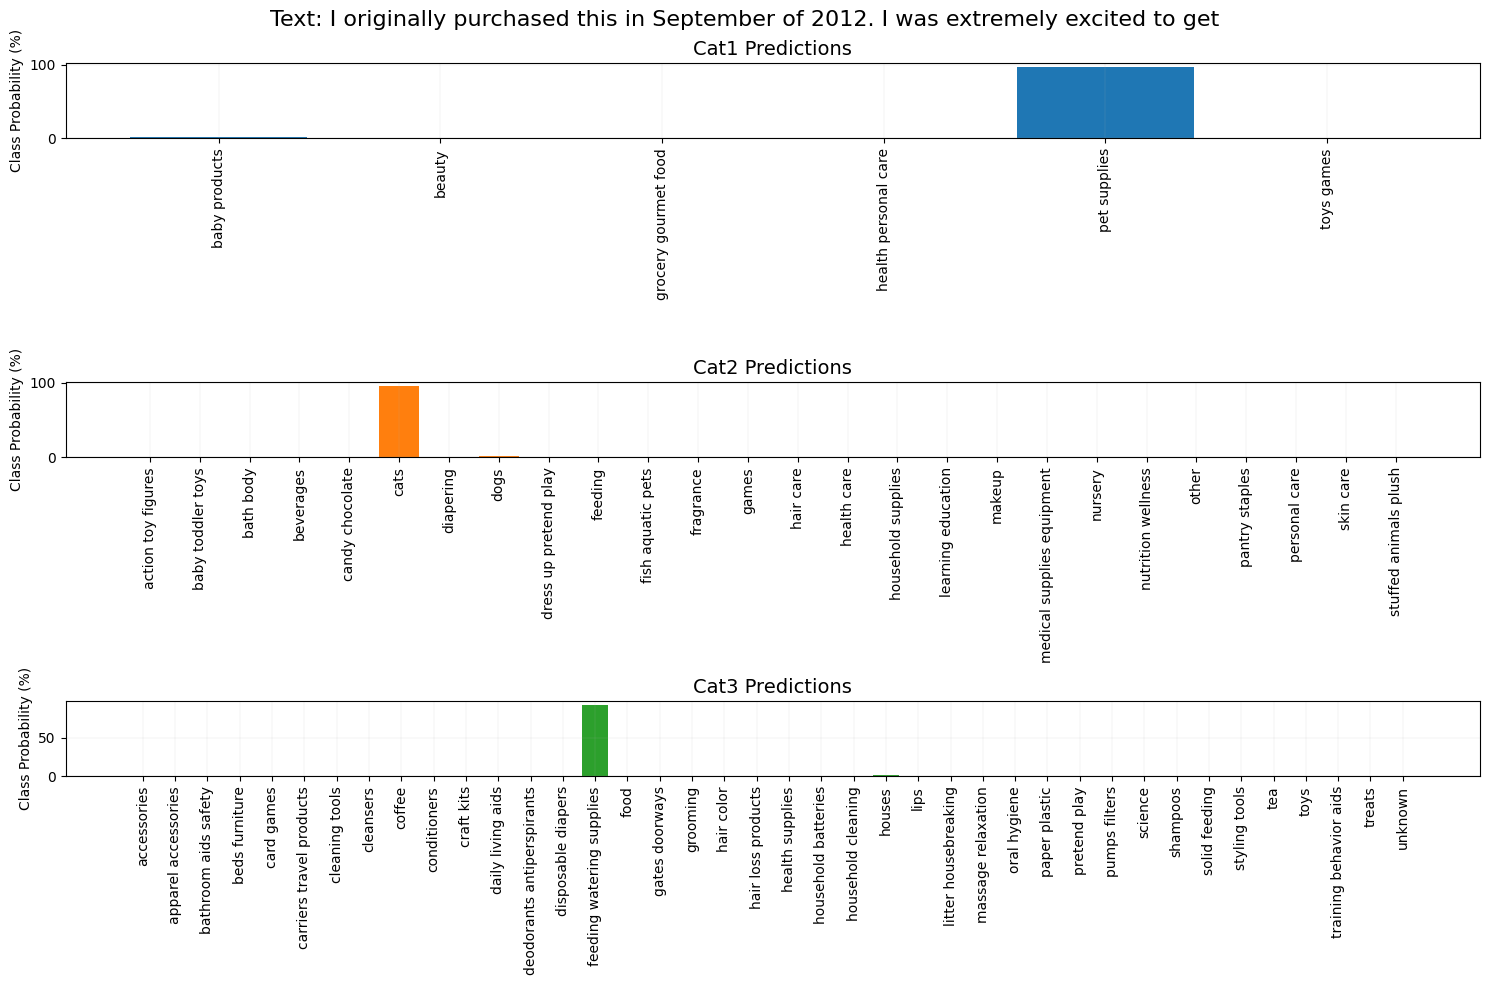

In [319]:
show_score_bar_multiple(input_s['Text'], score_dict)

In [324]:
print("Actual Labels:", input_s['Cat1'],input_s['Cat2'],input_s['Cat3'],sep='\n')

Actual Labels:
pet supplies
cats
feeding watering supplies


--------
## Evaluation on entire dataset..!

In [238]:
feature_df = pd.read_csv(r'C:\Users\abhij\Desktop\Transformers\Notebooks\Talentica\FeatureData.csv',index_col='Unnamed: 0')

In [274]:
%%time
cat1_prediction_df = generate_prediction_dataset(feature_df,model['model_cat1'])
feature_df["Cat1 Predictions"] = cat1_prediction_df['Predictions'].copy()

Device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index 511 has 572 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 520 has 973 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 658 has 559 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 963 has 747 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1010 has 804 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1038 has 687 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1325 has 754 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1685 has 529 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1778 has 528 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1894 has 581 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1950 has 665 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2091 has 621 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2137 has 521 tokens and exceeds 512 tokens! Truncating ...
⚠️ 

In [275]:
%%time
cat2_prediction_df = generate_prediction_dataset(feature_df,model['model_cat2'])
feature_df["Cat2 Predictions"] = cat2_prediction_df['Predictions'].copy()

Device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index 511 has 574 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 520 has 976 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 658 has 562 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 963 has 750 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1010 has 807 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1038 has 689 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1325 has 757 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1685 has 532 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1778 has 530 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1894 has 585 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1950 has 668 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2091 has 624 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2137 has 525 tokens and exceeds 512 tokens! Truncating ...
⚠️ 

In [276]:
%%time
cat3_prediction_df = generate_prediction_dataset(feature_df,model['model_cat3'])
feature_df["Cat3 Predictions"] = cat3_prediction_df['Predictions'].copy()

Device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


⚠️ Input at index 511 has 577 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 520 has 978 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 658 has 564 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 963 has 752 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1010 has 809 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1038 has 691 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1325 has 759 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1685 has 534 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1778 has 533 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1894 has 589 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 1950 has 672 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2091 has 626 tokens and exceeds 512 tokens! Truncating ...
⚠️ Input at index 2137 has 528 tokens and exceeds 512 tokens! Truncating ...
⚠️ 

---------------

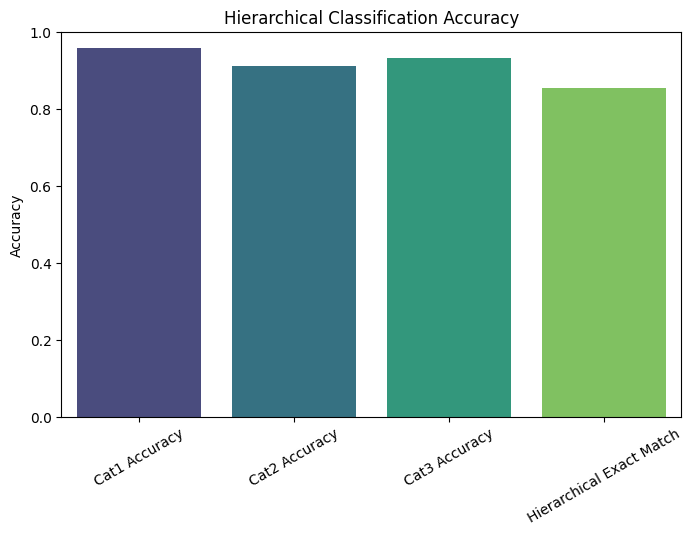

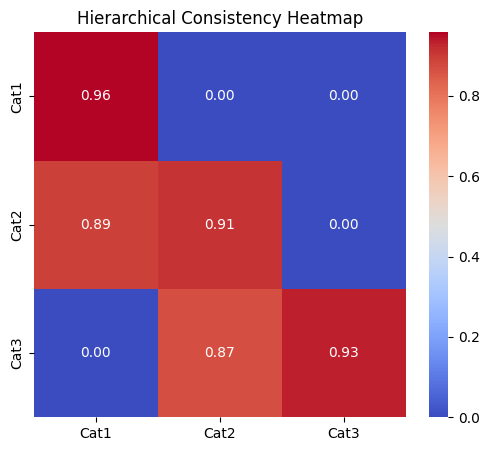

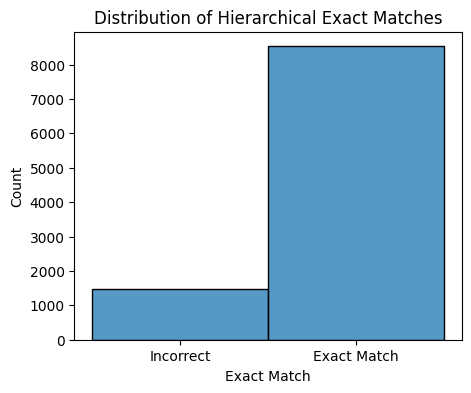

In [306]:
# Run visualization function
plot_hierarchical_results(feature_df)

In [307]:
hierarchical_evaluation(feature_df)

>>Accuracy :- 
Cat1: 0.9582, 
Cat2: 0.9310, 
Cat3: 0.9565
>>F1 Score :- 
Cat1: 0.9581, 
Cat2: 0.9054, 
Cat3: 0.9314
>>HEMR (Hierarchical Exact Match Ratio):- 0.8532


--------------
# THE END..